**Problem Statement**

With all of the tweets circulating every second it is hard to tell whether the sentiment behind a specific tweet will impact a company, or a person’s, brand for being viral (positive), or devastate profit because it strikes a negative tone. Capturing sentiment in language is important in these times where decisions and reactions are created and updated in seconds.   
In this notebook, we will try to **predict the sentiment behind a specific tweet**?

**Import necessary librairies**

In [ ]:
!pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
import re
import string
import nltk

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

import contractions
from textblob import TextBlob
from textblob import Word

**1. Datasets Overview**

In [ ]:
training = pd.read_csv("training.csv", sep=",", encoding="utf-8")
test = pd.read_csv("test.csv", sep=",", encoding="utf-8")


In [ ]:
# describes shape for training & test sets
print("Training set has {} rows and {} columns".format(training.shape[0],training.shape[1]))
print("Test set has {} rows and {} columns".format(test.shape[0],test.shape[1]))
# display first rows 
print("First 5 rows of training set \n")
training.head()

Training set has 27481 rows and 4 columns
Test set has 3534 rows and 3 columns
First 5 rows of training set 



,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [ ]:
print("First 5 rows of test set \n")
test.head()

First 5 rows of test set 



,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


- 'select_text' is only present on the training set.   
For the purpose of the study, we will only keep 'text' and 'sentiment' columns

In [ ]:
# replace '`' by '''
training['text'] = training['text'].str.replace("`", "'", regex=True)
test['text'] = test['text'].str.replace("`", "'", regex=True)

In [ ]:
# drop unecessary columns (e.g. select_text & textID)
training = training.drop(["textID","selected_text"],axis=1)
test = test.drop(["textID"],axis=1)

In [ ]:
#Inspect data types & missing values both in training & test set
print("------Data set Inspection------\n")
print("Analysis of training set : \n")
print(training.info())
print("Analysis of test set : \n")
print(test.info())
print("\n")
print("------# of missing values (training set)------\n")
missingValues_training = pd.DataFrame(training.isnull().sum(),columns=["missing"])
missingValues_test = pd.DataFrame(test.isnull().sum(),columns=["missing"])
print(missingValues_training)
print("------# of missing values (test set)------\n")
print(missingValues_test)

------Data set Inspection------

Analysis of training set : 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       27480 non-null  object
 1   sentiment  27481 non-null  object
dtypes: object(2)
memory usage: 429.5+ KB
None
Analysis of test set : 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3534 entries, 0 to 3533
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       3534 non-null   object
 1   sentiment  3534 non-null   object
dtypes: object(2)
memory usage: 55.3+ KB
None


------# of missing values (training set)------

           missing
text             1
sentiment        0
------# of missing values (test set)------

           missing
text             0
sentiment        0


- Only one entry is missing on the training set and will be removed later on.
- We need to covert 'sentiment' column into integers

In [ ]:
# drop lines with missing values (index 314)
training_sentiment = training.copy()
training_sentiment = training.dropna()

# sanity check 
training_sentiment.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27480 entries, 0 to 27480
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       27480 non-null  object
 1   sentiment  27480 non-null  object
dtypes: object(2)
memory usage: 644.1+ KB


**Analysis of 'sentiment' column**

In [ ]:
sentimentDist = training_sentiment.groupby('sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)
fig = go.Figure(go.Funnelarea(
    text =sentimentDist.sentiment,
    values = sentimentDist.text,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
    ))
fig.show()

Our target variable *Sentiment* is declined in 3 levels : positive, negative and neutral. Our training set comprises of 27, 480 tweets with the following repartition :
- 40.5% are neutral tweets,
- 31.2% are positive tweets,
- 28.3% are negative tweets.

**2. Data Cleaning**

Create a class function to perform data cleaning tasks and remove punctuation, remove stopwords @mention, lower & tokenize tweets.


In [ ]:
class text_cleaning():
    
    def count_regex(self, pattern, tweet):
        
        return len(re.findall(pattern, tweet))
    
    def punct(self, text):
        
        count= sum([1 for char in text if char in string.punctuation])
        return round(count/(len(text)-text.count(" ")),3)*100
    
    def count_text(self, text):
        
        return len(text)- text.count(" ")
    
    def clean_text(self,text):
        
        '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
        and remove words containing numbers.'''
        
        text = str(text).lower()
        text = re.sub("(.)\\1{2,}", "\\1", text)
        text = re.sub('\[.*?\]', ' ', text)
        text = re.sub('https?://\S+|www\.\S+', ' ', text)
        text = re.sub('<.*?>+', ' ', text)
        text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
        text = re.sub('\n', ' ', text)
        text = re.sub('\w*\d\w*', ' ', text)
        return text
    
    

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
stop = stopwords.words('english')
lemmatizer = WordNetLemmatizer()
words_keep =['no','nor','not']
new_stop_words = [word for word in stop if word not in words_keep] # keep 'not', "no" to not modify the overall sentence

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
# creates a dictionnary that corrects some similar words (e.g. 'Daddy'-->'Dad', 'okay'-->'ok')
dictOfStrings = {'daddy' : 'dad',
                 'okay' : 'ok',
                 'men' : 'man',
                 'mama' : "mother",
                 "mom":"mother",
                 "mum":"mother",
                 "saw" : "see",
                 "sunny" : "sun",
                 "funny" : "fun",
                 "sadly" : "sad",
                 "ya" : "yeah",
                 "yay" :"yeah",
                 "yea" : "yeah",
                 "photo" : "picture",
                 
                 'mommy': 'mother',
                 'til' : "till",
                 'yeahy': 'yeah',
                 'yeahh' : 'yeah',
                 'ahh' : 'ah',
                 'yep' : 'yes',
                 'babe':'baby',
                 'hahaha' : 'haha'      
                                          
                }

In [ ]:
textClean = text_cleaning() # import text Clening task 
# tasks to be performed
# 1. Correct contractions found in English language (e.g. 'I'm happy --> 'I am happy')
# 2. Remove punctions, @mention,special characters...
# 3. Tokenize tweets
# 4. Remove stop words (sw) 
# 5. Apply lemmantization (lm) on verbs & nouns

training_sentiment["expanded_text"] = training_sentiment['text'].apply(lambda x: [contractions.fix(word) for word in str(x).split()]).str.join(" ")
training_sentiment['cleaned_text']= training_sentiment['expanded_text'].apply(lambda x:textClean.clean_text(x))
training_sentiment['cleaned_text_tokenize']= training_sentiment['cleaned_text'].apply(nltk.word_tokenize)
training_sentiment['cleaned_text_tokenize_sw'] = training_sentiment['cleaned_text_tokenize'].apply(lambda x: [item for item in x if item not in set(new_stop_words)])
training_sentiment['cleaned_text_tokenize_lm'] = (training_sentiment['cleaned_text_tokenize_sw'].apply(lambda x: [lemmatizer.lemmatize(item, pos ="v") for item in x ]))
training_sentiment['cleaned_text_tokenize_lm_f'] = (training_sentiment['cleaned_text_tokenize_lm'].apply(lambda x: [lemmatizer.lemmatize(item, pos ="n") for item in x ])).str.join(" ")

# corrects similar words with the help of dictOfStrings

training_sentiment['cleaned_text_tokenize_lm_f'] = training_sentiment['cleaned_text_tokenize_lm_f'].replace(dictOfStrings, regex=True)


print("Intial tweet :{}".format(training_sentiment["text"].iloc[0]))
print("Clean contractions & punctuations :{}".format(training_sentiment["cleaned_text"].iloc[0]))
print("Final tweet (after data cleaning & tokenization) : ", training_sentiment["cleaned_text_tokenize_lm_f"].iloc[0])

Intial tweet : I'd have responded, if I were going
Clean contractions & punctuations :i would have responded  if i were going
Final tweet (after data cleaning & tokenization) :  would respond go


In [ ]:
# apply the same cleaning on submission file 

test["expanded_text"] = test['text'].apply(lambda x: [contractions.fix(word) for word in str(x).split()]).str.join(" ")
test['cleaned_text']= test['expanded_text'].apply(lambda x:textClean.clean_text(x))
test['cleaned_text_tokenize']= test['cleaned_text'].apply(nltk.word_tokenize)
test['cleaned_text_tokenize_sw'] = test['cleaned_text_tokenize'].apply(lambda x: [item for item in x if item not in set(new_stop_words)])
test['cleaned_text_tokenize_lm'] = (test['cleaned_text_tokenize_sw'].apply(lambda x: [lemmatizer.lemmatize(item, pos ="v") for item in x ]))
test['cleaned_text_tokenize_lm_f'] = (test['cleaned_text_tokenize_lm'].apply(lambda x: [lemmatizer.lemmatize(item, pos ="n") for item in x ])).str.join(" ")
test['cleaned_text_tokenize_lm_f'] = test['cleaned_text_tokenize_lm_f'].replace(dictOfStrings, regex=True)

print("Intial tweet :{}".format(test["text"].iloc[0]))
print("Clean contractions & punctuations :{}".format(test["cleaned_text"].iloc[0]))
print("Final tweet (after data cleaning & tokenization) : ", test["cleaned_text_tokenize_lm_f"].iloc[0])

Intial tweet :Last session of the day  http://twitpic.com/67ezh
Clean contractions & punctuations :last session of the day  
Final tweet (after data cleaning & tokenization) :  last session day


**3.Feature Engineering**¶

Creates additional features that computes : 

- tweet's length
- number of words contained in a tweet
- number of @mention, hashtags,urls...


In [ ]:
training_sentiment['text_length_initial'] = training_sentiment["text"].apply(lambda x: textClean.count_text(str(x)))
training_sentiment['text_length_final'] = training_sentiment["cleaned_text_tokenize_lm_f"].apply(lambda x: textClean.count_text(str(x)))

training_sentiment["count_words_initial"]= training_sentiment["text"].apply(lambda x: textClean.count_regex(r'\w+', str(x)))
training_sentiment["count_words_final"]= training_sentiment["cleaned_text_tokenize_lm_f"].apply(lambda x: textClean.count_regex(r'\w+', str(x)))

training_sentiment["count_mentions_initial"] = training_sentiment["text"].apply(lambda x: textClean.count_regex(r'@\w+', str(x)))
training_sentiment['punct%_initial'] = training_sentiment["text"].apply(lambda x: textClean.punct(str(x)))

training_sentiment['count_hashtags_initial'] = training_sentiment["text"].apply(lambda x: textClean.count_regex(r'#\w+', str(x)))
training_sentiment['count_urls_initial'] = training_sentiment["text"].apply(lambda x: textClean.count_regex(r'http.?://[^\s]+[\s]?', str(x)))

print("Intial tweet:{}".format(training_sentiment["text"].iloc[0]))
print("Intial tweet length :{}".format(training_sentiment["text_length_initial"].iloc[0]))
print("Final tweet length :{}".format(training_sentiment["text_length_final"].iloc[0]))
print("Count words initial:{}".format(training_sentiment["count_words_initial"].iloc[0]))
print("Count words final:{}".format(training_sentiment["count_words_final"].iloc[0]))
print("Count Mentions: ", training_sentiment["count_mentions_initial"].iloc[0])
print("Count Punctuations: ", training_sentiment["punct%_initial"].iloc[0])
print("Count Hashtags: ", training_sentiment["count_hashtags_initial"].iloc[0])
print("Count Urls: ", training_sentiment["count_urls_initial"].iloc[0])

Intial tweet: I'd have responded, if I were going
Intial tweet length :29
Final tweet length :14
Count words initial:8
Count words final:3
Count Mentions:  0
Count Punctuations:  6.9
Count Hashtags:  0
Count Urls:  0


**Feature Engineering Analysis**

 Distribution of initial tweet length, #of words, hashtages, URls and punction split by sentiment



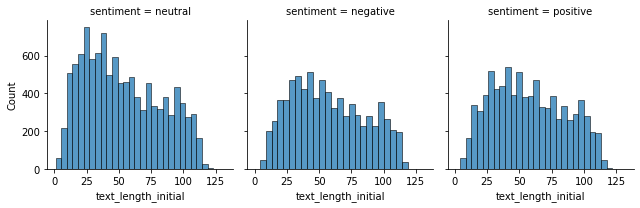

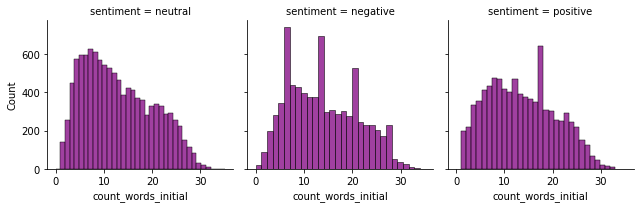

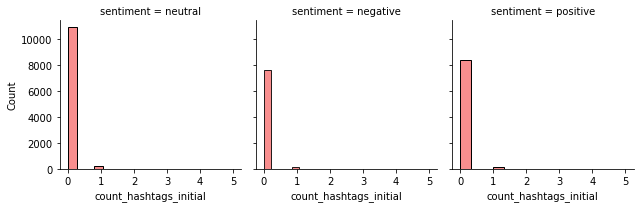

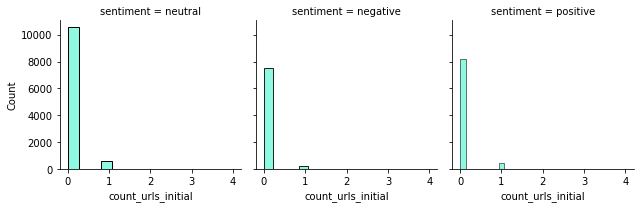

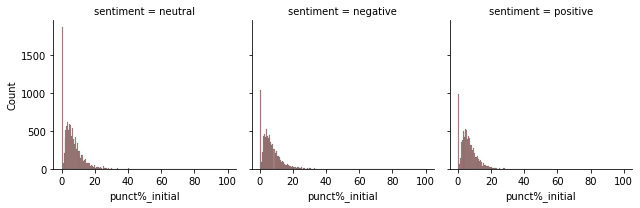

In [ ]:
print(" Distribution of initial tweet length, #of words, hashtages, URls and punction split by sentiment\n")

g = sns.FacetGrid(training_sentiment, col="sentiment")
g.map(sns.histplot, "text_length_initial")
plt.show()

g = sns.FacetGrid(training_sentiment, col="sentiment")
g.map(sns.histplot, "count_words_initial", color="purple")
plt.show()

g = sns.FacetGrid(training_sentiment, col="sentiment")
g.map(sns.histplot, "count_hashtags_initial", color="#F66868")
plt.show()

g = sns.FacetGrid(training_sentiment, col="sentiment")
g.map(sns.histplot, "count_urls_initial", color="#68F6D8")
plt.show()

g = sns.FacetGrid(training_sentiment, col="sentiment")
g.map(sns.histplot, "punct%_initial", color="#936060")
plt.show()

**4.Function to map stars to sentiment**

In [ ]:

def map_sentiment(x):
    if x == "neutral":
        return 0
    elif x == "negative":
        return -1
    else:
        return 1
# Mapping stars to sentiment into three categories
training_sentiment['target'] = [ map_sentiment(x) for x in training_sentiment['sentiment']]
test['target'] = [ map_sentiment(x) for x in test['sentiment']]


**5. Word Cloud**

In [ ]:
from wordcloud import WordCloud
def display_wordCloud(classes = 1):
  positive_words =' '.join([text for text in training_sentiment['cleaned_text_tokenize_lm_f'][training_sentiment['target'] == classes]]) 
  wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(positive_words)
  plt.figure(figsize=(10, 7))
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.axis('off')
  plt.show()


- Word Cloud (Positive Tweets)


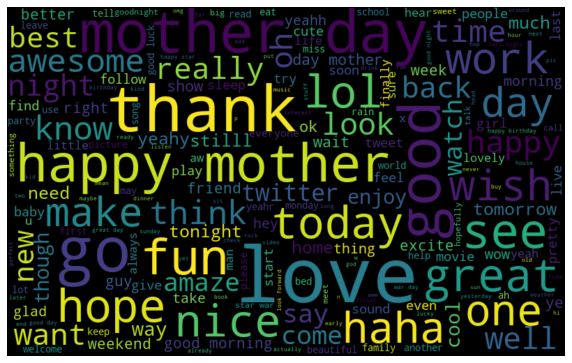

In [ ]:
display_wordCloud(classes = 1)

- Word Cloud (Neutral tweets)

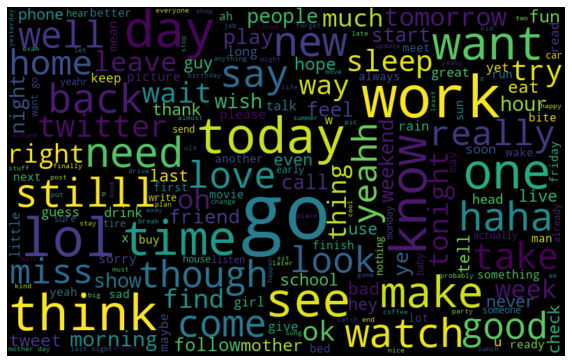

In [ ]:
display_wordCloud(classes = 0)

- Word Cloud (Negative tweets)

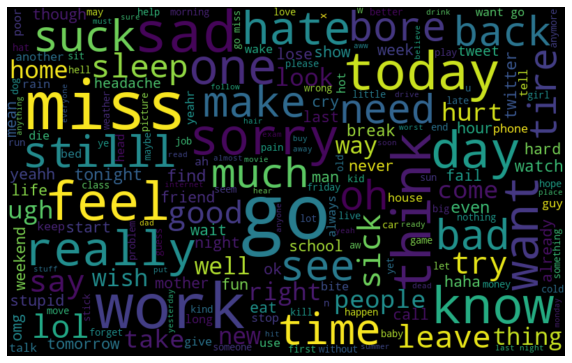

In [ ]:
display_wordCloud(classes = -1)

**6. Modelisation Part**

We first start by **spliting** our training set into two part :
- 80% will be allocated for training purpose
- 20% for validation

We also investigated the **distribution** across the target variable to see if the labels are equally distributed (e.g. investigation of imbalanced classification problem) on both the **training** & the **validation** sets.

In [ ]:
from sklearn.model_selection import train_test_split
# Train Test Split Function
  
X_train, X_val, Y_train, Y_val = train_test_split(training_sentiment['cleaned_text_tokenize_lm_f'], 
                                                  training_sentiment['target'], 
                                                  shuffle=True,
                                                  test_size=0.3, 
                                                  random_state=15)
    
print("Target variable distribution (Training set)\n",Y_train.value_counts())
print("Target variable distribution (Validation set)\n",Y_val.value_counts())

Target variable distribution (Training set)
  0    7788
 1    6054
-1    5394
Name: target, dtype: int64
Target variable distribution (Validation set)
  0    3329
 1    2528
-1    2387
Name: target, dtype: int64


**6.1 Type of approaches**



We will start by creating a baseline model using three classifiers (LR, RF and NB) , CountVectorizer and TF-IDF approaches.  
From [Scikit-Learn's documentation](https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html) : 
> (1) In order to perform machine learning on text documents, we first need to turn the text content into numerical feature vectors.

> (2) The most intuitive way to do so is to use a bags of words representation

Drawbacks of Bags of words approach: 
- most values will be **zeros** resulting in high-dimensional sparse matrix.
- longer documents will have higher average count values than shorter documents, even though they might talk about the same topics.

To avoid these potential discrepancies, another approach is to turn occurences into frequencies by dividing the number of occurrences of each word in a document by the total number of words in the document (e.g. *term frequency*).  

Another refinement on top of tf is to downscale weights for words that occur in many documents in the corpus and are therefore less informative than those that occur only in a smaller portion of the corpus.

This downscaling is called tf–idf for **Term Frequency times Inverse Document Frequency**.

In [ ]:
def count_vectorizer(max_features = 500, ngram_range = (1,1)):
    
    cv = CountVectorizer(max_features = max_features, ngram_range = ngram_range)
    return cv 

def tfidf_vectorizer(max_features = 1000, ngram_range = (1,1)):
    
    tv = TfidfVectorizer(max_features = max_features, ngram_range = ngram_range)
    return tv 
    

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

# We'll test 3 approaches :
# 1. unigram (1,1)
# 2. bigram (2,2)
# 3. trigram (3,3)


cv = count_vectorizer(max_features = 500, ngram_range = (1,1)) # up to 500 words
tv = tfidf_vectorizer(max_features = 1000, ngram_range = (1,1)) # up to 1 000 words

cv_uni_bi = count_vectorizer(max_features = 500, ngram_range = (1,2))
tv_uni_bi = tfidf_vectorizer(max_features = 1000, ngram_range = (1,2))

cv_uni_tri = count_vectorizer(max_features = 500, ngram_range = (1,3))
tv_uni_tri = tfidf_vectorizer(max_features = 1000, ngram_range = (1,3))

#cv_bi = count_vectorizer(max_features = 500, ngram_range = (2,2))
#tv_bi = tfidf_vectorizer(max_features = 1000, ngram_range = (2,2))

#cv_tri = count_vectorizer(max_features = 500, ngram_range = (3,3))
#tv_tri = tfidf_vectorizer(max_features = 1000, ngram_range = (3,3))

#cv_bi_tri = count_vectorizer(max_features = 500, ngram_range = (2,3))
#tv_bi_tri = tfidf_vectorizer(max_features = 1000, ngram_range = (2,3))


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

In [ ]:
def transform_features_train(cv):
    
    data = pd.DataFrame(cv.fit_transform(X_train).toarray(), columns=cv.get_feature_names_out())
    return data

def transform_features_test(cv, test):
    
    data = pd.DataFrame(cv.transform(test).toarray(), columns=cv.get_feature_names_out())
    return data

def add_features(train):
    
    list_features = ["text_length_final","count_words_final"]
    data = pd.merge(train, training_sentiment[list_features], left_index=True, right_index=True).reset_index()
    data = data[list_features]
    
    return data

def scale_features(features):
    
    ct = ColumnTransformer([
        ('somename', StandardScaler(), features.columns)
    ], remainder='passthrough')
    
    return ct

    
    
    
def merge_features_data(train, data):
    
    new_data = pd.merge(train, data, left_index=True, right_index=True)
        
    return new_data

In [ ]:
# unigram
X_train_bow = transform_features_train(cv) # bow approach
X_train_tf = transform_features_train(tv) # tf-idf approach

# uni-bi-gram
X_train_bow_uni_bi = transform_features_train(cv_uni_bi)
X_train_tf_uni_bi = transform_features_train(tv_uni_bi)

# uni-tri gram
X_train_bow_uni_tri = transform_features_train(cv_uni_tri)
X_train_tf_uni_tri = transform_features_train(tv_uni_tri)

#bi gram
#X_train_bow_bi = transform_features_train(cv_bi)
#X_train_tf_bi = transform_features_train(tv_bi)

#tri gram
#X_train_bow_tri = transform_features_train(cv_tri)
#X_train_tf_tri = transform_features_train(tv_tri)

# bi et tri-gram
#X_train_bow_bi_tri = transform_features_train(cv_bi_tri)
#X_train_tf_bi_tri = transform_features_train(tv_bi_tri)





In [ ]:
# application on valdition set

In [ ]:
X_val_bow = transform_features_test(cv,X_val)
X_val_tf = transform_features_test(tv,X_val)

X_val_bow_uni_bi = transform_features_test(cv_uni_bi,X_val)
X_val_tf_uni_bi = transform_features_test(tv_uni_bi,X_val)

X_val_bow_uni_tri = transform_features_test(cv_uni_tri,X_val)
X_val_tf_uni_tri = transform_features_test(tv_uni_tri,X_val)

#X_val_bow_bi = transform_features_test(cv_bi,X_val)
#X_val_tf_bi = transform_features_test(tv_bi,X_val)

#X_val_bow_tri = transform_features_test(cv_tri,X_val)
#X_val_tf_tri = transform_features_test(tv_tri,X_val)

#X_val_bow_bi_tri = transform_features_test(cv_bi_tri,X_val)
#X_val_tf_bi_tri = transform_features_test(tv_bi_tri,X_val)



**6.2 Classifier**

We'll test three classifiers and do some hyperparameter tuning.  
For each classifier the following functions will perform the following tasks based on the type of approach (e.g. uni, bi, tri gram,...):
- The best hyperparameters based on F1 Score.
- Compute the confusion matrix 

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import  make_scorer
from sklearn.svm import SVC

In [ ]:
def lr_grid(training, testing):
    
    lr = LogisticRegression(solver='lbfgs', max_iter=1000)
    param_grid = {"C":[1e-2, 1e-1,1, 10, 100]}
    f1 = make_scorer(f1_score , average = 'macro')
    grid = GridSearchCV(lr, cv=5,scoring=f1, param_grid=param_grid, n_jobs=-1, verbose = 10)
    grid.fit(training, Y_train)
    #print("Grid-Search with roc_auc\n")
    print("Best parameters:\n", grid.best_params_)
    #print("Best cross-validation score (f1)): {:.3f}\n".format(grid.best_score_))
    y_predict = grid.predict(testing)
    print("The macro F1 score with the best hyperparameters is \n", end = '')
    print(f1_score(Y_val, y_predict, average = 'macro'))
    print ("Classification Report: ")
    print (classification_report(Y_val, y_predict))
    return f1_score(Y_val, y_predict, average = 'macro')

In [ ]:
def rf(training, testing):
    clfRF =  RandomForestClassifier()
    
    param_grid = {'n_estimators': [20, 50, 100], 'criterion' :['gini', 'entropy']}
    f1 = make_scorer(f1_score , average = 'macro')
    grid = GridSearchCV(clfRF, cv=5,scoring=f1, param_grid=param_grid, n_jobs=-1, verbose = 10)
    grid.fit(training, Y_train)
    
    #print("Grid-Search with roc_auc")
    print("Best parameters:", grid.best_params_)
    #print("Best cross-validation score (f1)): {:.3f}".format(grid.best_score_))
    y_predict = grid.predict(testing)
    print("The macro F1 score with the best hyperparameters is ", end = '')
    print(f1_score(Y_val, y_predict, average = 'macro'))
    print ("Classification Report: ")
    print (classification_report(Y_val, y_predict))
    return f1_score(Y_val, y_predict, average = 'macro')

In [ ]:
def mnb(training, testing):
    clfNB =  MultinomialNB()
    
    param_grid = {'alpha': [0.0001, 0.001, 0.1, 1, 10]}
    f1 = make_scorer(f1_score , average = 'macro')
    grid = GridSearchCV(clfNB, cv=5,scoring=f1, param_grid=param_grid, n_jobs=-1, verbose = 10)
    grid.fit(training, Y_train)
    
    #print("Grid-Search with roc_auc")
    print("Best parameters:", grid.best_params_)
    #print("Best cross-validation score (f1)): {:.3f}".format(grid.best_score_))
    y_predict = grid.predict(testing)
    print("The macro F1 score with the best hyperparameters is ", end = '')
    print(f1_score(Y_val, y_predict, average = 'macro'))
    print ("Classification Report: ")
    print (classification_report(Y_val, y_predict))
    return f1_score(Y_val, y_predict, average = 'macro')

**Train a Logistic regression using  BOW Approach** 

In [ ]:
print("LR for BOW unigram approach....")
f1_score_uni = lr_grid(X_train_bow,X_val_bow)
print("\n")
print("LR for BOW uni & bi gram approach....")
f1_score_uni_bi = lr_grid(X_train_bow_uni_bi,X_val_bow_uni_bi)
print("\n")
print("LR for BOW uni & tri gram approach....")
f1_score_uni_tri = lr_grid(X_train_bow_uni_tri, X_val_bow_uni_tri)
#print("\n")
#print("LR for BOW bi gram approach....")
#f1_score_bi = lr_grid(X_train_bow_bi, X_val_bow_bi)
#print("\n")
#print("LR for BOW tri gram approach....")
#f1_score_tri = lr_grid(X_train_bow_tri, X_val_bow_tri)
#print("\n")
#print("LR for BOW bi & tri gram approach....")
#f1_score_bi_tri = lr_grid(X_train_bow_bi_tri, X_val_bow_bi_tri)


LR for BOW unigram approach....
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters:
 {'C': 1}
The macro F1 score with the best hyperparameters is 
0.6829155090588981
Classification Report: 
              precision    recall  f1-score   support

          -1       0.71      0.55      0.62      2387
           0       0.62      0.74      0.68      3329
           1       0.77      0.74      0.75      2528

    accuracy                           0.68      8244
   macro avg       0.70      0.68      0.68      8244
weighted avg       0.69      0.68      0.68      8244



LR for BOW uni & bi gram approach....
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters:
 {'C': 1}
The macro F1 score with the best hyperparameters is 
0.6852871439372445
Classification Report: 
              precision    recall  f1-score   support

          -1       0.72      0.56      0.63      2387
           0       0.62      0.75      0.68      3329
           1      

**Final Result (Logistic Regression)**

In [ ]:
results_LRClassifier = pd.DataFrame(
                                  index=['LR - Unigram', 'LR - Uni & bi gram','LR - Uni & tri gram'
                                        ],
                                  columns=["f1-score"])

results_LRClassifier.loc['LR - Unigram'] = f1_score_uni
results_LRClassifier.loc['LR - Uni & bi gram'] = f1_score_uni_bi
results_LRClassifier.loc['LR - Uni & tri gram'] = f1_score_uni_tri
results_LRClassifier

,f1-score
LR - Unigram,0.682916
LR - Uni & bi gram,0.685287
LR - Uni & tri gram,0.68652


**Train a Random Forest using BOW Approach**

In [ ]:
print("RF for BOW approach....")
f1_score_uni = rf(X_train_bow,X_val_bow)
print("\n")
print("RF for BOW uni & bi gram approach....")
f1_score_uni_bi = rf(X_train_bow_uni_bi,X_val_bow_uni_bi)
print("\n")
print("RF for BOW uni & tri gram approach....")
f1_score_uni_tri = rf(X_train_bow_uni_tri, X_val_bow_uni_tri)
#print("\n")
#print("RF for BOW bi gram approach....")
#f1_score_bi = rf(X_train_bow_bi, X_val_bow_bi)
#print("\n")
#print("RF for BOW tri gram approach....")
#f1_score_tri = rf(X_train_bow_tri, X_val_bow_tri)
#print("\n")
#print("RF for BOW bi & tri gram approach....")
#f1_score_bi_tri = rf(X_train_bow_bi_tri, X_val_bow_bi_tri)

RF for BOW approach....
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters: {'criterion': 'entropy', 'n_estimators': 100}
The macro F1 score with the best hyperparameters is 0.6737072352696326
Classification Report: 
              precision    recall  f1-score   support

          -1       0.65      0.61      0.63      2387
           0       0.64      0.65      0.65      3329
           1       0.74      0.75      0.74      2528

    accuracy                           0.67      8244
   macro avg       0.67      0.67      0.67      8244
weighted avg       0.67      0.67      0.67      8244



RF for BOW uni & bi gram approach....
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters: {'criterion': 'entropy', 'n_estimators': 50}
The macro F1 score with the best hyperparameters is 0.6722282094998135
Classification Report: 
              precision    recall  f1-score   support

          -1       0.65      0.60      0.62      2387
           

In [ ]:
results_RFClassifier = pd.DataFrame(
                                  index=['RF - Unigram', 'RF - Uni & bi gram','RF - Uni & tri gram'
                                        ],
                                  columns=["f1-score"])

results_RFClassifier.loc['RF - Unigram'] = f1_score_uni
results_RFClassifier.loc['RF - Uni & bi gram'] = f1_score_uni_bi
results_RFClassifier.loc['RF - Uni & tri gram'] = f1_score_uni_tri
results_RFClassifier

,f1-score
RF - Unigram,0.673707
RF - Uni & bi gram,0.672228
RF - Uni & tri gram,0.6737


**Train a Naive Bayes using BOW approach**

In [ ]:
print("mnb for BOW approach....")
f1_score_uni = mnb(X_train_bow,X_val_bow)
print("\n")
print("mnb for BOW uni & bi gram approach....")
f1_score_uni_bi = mnb(X_train_bow_uni_bi,X_val_bow_uni_bi)
print("\n")
print("mnb for BOW uni & tri gram approach....")
f1_score_uni_tri = mnb(X_train_bow_uni_tri, X_val_bow_uni_tri)
#print("\n")
#print("mnb for BOW bi gram approach....")
#f1_score_bi = mnb(X_train_bow_bi, X_val_bow_bi)
#print("\n")
#print("mnb for BOW tri gram approach....")
#f1_score_tri = mnb(X_train_bow_tri, X_val_bow_tri)
#print("\n")
#print("mnb for BOW bi & tri gram approach....")
#f1_score_bi_tri = mnb(X_train_bow_bi_tri, X_val_bow_bi_tri)

mnb for BOW approach....
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters: {'alpha': 10}
The macro F1 score with the best hyperparameters is 0.6602308376810769
Classification Report: 
              precision    recall  f1-score   support

          -1       0.71      0.53      0.61      2387
           0       0.59      0.74      0.66      3329
           1       0.75      0.68      0.71      2528

    accuracy                           0.66      8244
   macro avg       0.68      0.65      0.66      8244
weighted avg       0.67      0.66      0.66      8244



mnb for BOW uni & bi gram approach....
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters: {'alpha': 10}
The macro F1 score with the best hyperparameters is 0.6592991766917082
Classification Report: 
              precision    recall  f1-score   support

          -1       0.70      0.55      0.61      2387
           0       0.59      0.75      0.66      3329
           1      

In [ ]:
results_NBClassifier = pd.DataFrame(
                                  index=['NB - Unigram', 'NB - Uni & bi gram','NB - Uni & tri gram'
                                        ],
                                  columns=["f1-score"])

results_NBClassifier.loc['NB - Unigram'] = f1_score_uni
results_NBClassifier.loc['NB - Uni & bi gram'] = f1_score_uni_bi
results_NBClassifier.loc['NB - Uni & tri gram'] = f1_score_uni_tri
results_NBClassifier

,f1-score
NB - Unigram,0.660231
NB - Uni & bi gram,0.659299
NB - Uni & tri gram,0.661527


**Train a Logistic regression using TF-IDF approach**

In [ ]:
print("LR for tfidf unigram approach....")
f1_score_uni = lr_grid(X_train_tf,  X_val_tf)
print("\n")
print("LR for tfid uni & bi gram approach....")
f1_score_uni_bi = lr_grid(X_train_tf_uni_bi, X_val_tf_uni_bi)
print("\n")
print("LR for tfid uni & tri gram approach....")
f1_score_uni_tri = lr_grid(X_train_tf_uni_tri, X_val_tf_uni_tri)
#print("\n")
#print("LR for tfid bi gram approach....")
#f1_score_bi = lr_grid(X_train_tf_bi, X_val_tf_bi)
#print("\n")
#print("LR for tfid tri gram approach....")
#f1_score_tri = lr_grid(X_train_tf_tri, X_val_tf_tri)
#print("\n")
#print("LR for tfid bi & tri gram approach....")
#f1_score_bi_tri = lr_grid(X_train_tf_bi_tri, X_val_tf_bi_tri)

LR for tfidf unigram approach....
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters:
 {'C': 1}
The macro F1 score with the best hyperparameters is 
0.6993396167814465
Classification Report: 
              precision    recall  f1-score   support

          -1       0.73      0.60      0.65      2387
           0       0.63      0.74      0.68      3329
           1       0.78      0.74      0.76      2528

    accuracy                           0.70      8244
   macro avg       0.71      0.69      0.70      8244
weighted avg       0.71      0.70      0.70      8244



LR for tfid uni & bi gram approach....
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters:
 {'C': 1}
The macro F1 score with the best hyperparameters is 
0.7022155822364081
Classification Report: 
              precision    recall  f1-score   support

          -1       0.73      0.61      0.66      2387
           0       0.64      0.74      0.68      3329
           1   

In [ ]:
results_LRClassifier = pd.DataFrame(
                                  index=['LR - Unigram', 'LR - Uni & bi gram','LR - Uni & tri gram'
                                        ],
                                  columns=["f1-score"])

results_LRClassifier.loc['LR - Unigram'] = f1_score_uni
results_LRClassifier.loc['LR - Uni & bi gram'] = f1_score_uni_bi
results_LRClassifier.loc['LR - Uni & tri gram'] = f1_score_uni_tri
results_LRClassifier

,f1-score
LR - Unigram,0.69934
LR - Uni & bi gram,0.702216
LR - Uni & tri gram,0.702973


**Train a Random Forest using TF-IDF approach**

In [ ]:
print("RF for tf approach....")
f1_score_uni = rf(X_train_tf,  X_val_tf)
print("\n")
print("RF for tf uni & bi gram approach....")
f1_score_uni_bi = rf(X_train_tf_uni_bi, X_val_tf_uni_bi)
print("\n")
print("RF for tf uni & tri gram approach....")
f1_score_uni_tri = rf(X_train_tf_uni_tri, X_val_tf_uni_tri)
#print("\n")
#print("RF for tf bi gram approach....")
#f1_score_bi = rf(X_train_tf_bi, X_val_tf_bi)
#print("\n")
#print("RF for tf tri gram approach....")
#f1_score_tri = rf(X_train_tf_tri, X_val_tf_tri)
#print("\n")
#print("RF for tf bi & tri gram approach....")
#f1_score_bi_tri = rf(X_train_tf_bi_tri, X_val_tf_bi_tri)

RF for tf approach....
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters: {'criterion': 'entropy', 'n_estimators': 100}
The macro F1 score with the best hyperparameters is 0.702166124743752
Classification Report: 
              precision    recall  f1-score   support

          -1       0.72      0.62      0.67      2387
           0       0.66      0.71      0.68      3329
           1       0.75      0.77      0.76      2528

    accuracy                           0.70      8244
   macro avg       0.71      0.70      0.70      8244
weighted avg       0.70      0.70      0.70      8244



RF for tf uni & bi gram approach....
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters: {'criterion': 'entropy', 'n_estimators': 50}
The macro F1 score with the best hyperparameters is 0.6988752165918606
Classification Report: 
              precision    recall  f1-score   support

          -1       0.71      0.61      0.66      2387
           0  

In [ ]:
results_RFClassifier = pd.DataFrame(
                                  index=['RF - Unigram', 'RF - Uni & bi gram','RF - Uni & tri gram'
                                        ],
                                  columns=["f1-score"])

results_RFClassifier.loc['RF - Unigram'] = f1_score_uni
results_RFClassifier.loc['RF - Uni & bi gram'] = f1_score_uni_bi
results_RFClassifier.loc['RF - Uni & tri gram'] = f1_score_uni_tri
results_RFClassifier

,f1-score
RF - Unigram,0.702166
RF - Uni & bi gram,0.698875
RF - Uni & tri gram,0.703954


**Train a Naive Bayes using TF-IDF approach**

In [ ]:
print("MNB for tf approach....")
f1_score_uni = mnb(X_train_tf,  X_val_tf)
print("\n")
print("MNB for tf uni & bi gram approach....")
f1_score_uni_bi = mnb(X_train_tf_uni_bi, X_val_tf_uni_bi)
print("\n")
print("MNB for tf uni & tri gram approach....")
f1_score_uni_tri = mnb(X_train_tf_uni_tri, X_val_tf_uni_tri)
#print("\n")
#print("MNB for tf bi gram approach....")
#f1_score_bi = mnb(X_train_tf_bi, X_val_tf_bi)
#print("\n")
#print("MNB for tf tri gram approach....")
#f1_score_tri = mnb(X_train_tf_tri, X_val_tf_tri)
#print("\n")
#print("MNB for tf bi & tri gram approach....")
#f1_score_bi_tri = mnb(X_train_tf_bi_tri, X_val_tf_bi_tri)

MNB for tf approach....
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters: {'alpha': 1}
The macro F1 score with the best hyperparameters is 0.6468373468440903
Classification Report: 
              precision    recall  f1-score   support

          -1       0.74      0.48      0.58      2387
           0       0.57      0.79      0.66      3329
           1       0.77      0.63      0.70      2528

    accuracy                           0.65      8244
   macro avg       0.69      0.63      0.65      8244
weighted avg       0.68      0.65      0.65      8244



MNB for tf uni & bi gram approach....
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters: {'alpha': 1}
The macro F1 score with the best hyperparameters is 0.650747938299267
Classification Report: 
              precision    recall  f1-score   support

          -1       0.73      0.50      0.59      2387
           0       0.57      0.79      0.66      3329
           1       0.79

In [ ]:
results_NBClassifier = pd.DataFrame(
                                  index=['NB - Unigram', 'NB - Uni & bi gram','NB - Uni & tri gram'
                                        ],
                                  columns=["f1-score"])

results_NBClassifier.loc['NB - Unigram'] = f1_score_uni
results_NBClassifier.loc['NB - Uni & bi gram'] = f1_score_uni_bi
results_NBClassifier.loc['NB - Uni & tri gram'] = f1_score_uni_tri
results_NBClassifier

,f1-score
NB - Unigram,0.646837
NB - Uni & bi gram,0.650748
NB - Uni & tri gram,0.651263


The best model is Random Forest with the following hyperparameters:
- {criterion : entropy, n_estimators : 100}, with a uni-tri-gram approach.

**7. Predictions on test set**

In [ ]:
X_test, y_test = test["cleaned_text_tokenize_lm_f"], test["target"]

In [ ]:
X_test_sub_tf_uni_tri = transform_features_test(tv_uni_tri,X_test)

In [ ]:
clfRF =  RandomForestClassifier(criterion = 'entropy', n_estimators = 100)
clfRF.fit(X_train_tf_uni_tri, Y_train)
y_val = clfRF.predict(X_val_tf_uni_tri)
y_test_sub = clfRF.predict(X_test_sub_tf_uni_tri)

print("f1_score validation score :",f1_score(Y_val, y_val, average = 'macro'))
print("f1_score test score :",f1_score(y_test, y_test_sub, average = 'macro'))
print ("Classification Report validation: ")
print (classification_report(Y_val, y_val))

print ("Classification Report test: ")
print (classification_report(y_test, y_test_sub))

f1_score validation score : 0.702328120630026
f1_score test score : 0.6954247423837989
Classification Report validation: 
              precision    recall  f1-score   support

          -1       0.71      0.61      0.66      2387
           0       0.65      0.71      0.68      3329
           1       0.76      0.78      0.77      2528

    accuracy                           0.70      8244
   macro avg       0.71      0.70      0.70      8244
weighted avg       0.70      0.70      0.70      8244

Classification Report test: 
              precision    recall  f1-score   support

          -1       0.71      0.63      0.67      1001
           0       0.64      0.69      0.67      1430
           1       0.76      0.75      0.75      1103

    accuracy                           0.69      3534
   macro avg       0.70      0.69      0.70      3534
weighted avg       0.70      0.69      0.69      3534



**8. Applying Word2vec approach**

In [ ]:
import gensim 
data_review_text = training_sentiment['cleaned_text_tokenize_lm_f'].apply(nltk.word_tokenize)
model = gensim.models.Word2Vec(
    size = 300,
    window=5,
    min_count=2,
    workers=4,
    sg = 1
)
model.build_vocab(data_review_text, progress_per=1000)
model.train(data_review_text, total_examples=model.corpus_count, epochs=model.epochs)

(787557, 968905)

In [ ]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0
    for word in tokens:
        try:
            vec += model.wv[word].reshape((1, size))
            count += 1.
        except KeyError:  # handling the case where the token is not in vocabulary
            continue
    if count != 0:
        vec /= count
    return vec

In [ ]:
train_df = pd.concat([X_train, Y_train], axis=1, join='inner')
val_df = pd.concat([X_val, Y_val], axis=1, join='inner')
submission = test[["cleaned_text_tokenize_lm_f","target"]]

In [ ]:
train_review_text = train_df.copy().reset_index()
train_review_text["tokenize"] = train_review_text["cleaned_text_tokenize_lm_f"].apply(nltk.word_tokenize)
train_review = train_review_text["tokenize"]

In [ ]:
val_review_text = val_df.copy().reset_index()
val_review_text["tokenize"] = val_review_text["cleaned_text_tokenize_lm_f"].apply(nltk.word_tokenize)
val_review = val_review_text["tokenize"]

In [ ]:
submission_text = submission.copy()
submission_text["tokenize"] = submission_text["cleaned_text_tokenize_lm_f"].apply(nltk.word_tokenize)
submission_review = submission_text["tokenize"]


In [ ]:
wordvec_arrays_train = np.zeros((len(train_review), 300)) 
for i in range(len(train_review.index)):
    
    wordvec_arrays_train[i,:] = word_vector(train_review[i], 300)
wordvec_df_train = pd.DataFrame(wordvec_arrays_train)
print(wordvec_df_train.shape)

(19236, 300)


In [ ]:
wordvec_arrays_val = np.zeros((len(val_review), 300)) 
for i in range(len(val_review)):
    
    wordvec_arrays_val[i,:] = word_vector(val_review[i], 300)
wordvec_df_val = pd.DataFrame(wordvec_arrays_val)
print(wordvec_df_val.shape)

(8244, 300)


In [ ]:
wordvec_arrays_test = np.zeros((len(submission_review), 300)) 
for i in range(len(submission_review)):
    
    wordvec_arrays_test[i,:] = word_vector(submission_review[i], 300)
wordvec_df_test = pd.DataFrame(wordvec_arrays_test)
print(wordvec_df_test.shape)

(3534, 300)


**Apply RandomForest with Gensim model**

In [ ]:
clfRF =  RandomForestClassifier(criterion = 'entropy', n_estimators = 100)
clfRF.fit(wordvec_df_train, train_review_text["target"])
pred_val = clfRF.predict(wordvec_df_val)
pred_test = clfRF.predict(wordvec_df_test)
print("f1 score val: \n",f1_score(val_review_text["target"], pred_val, average='macro'))
print("f1 score test: \n",f1_score(submission_text["target"], pred_test, average='macro'))

print ("CR val :\n",classification_report(val_review_text["target"], pred_val))
print ("CR test :\n",classification_report(submission_text["target"], pred_test))

f1 score val: 
 0.5977425667872533
f1 score test: 
 0.6104003462497279
CR val :
               precision    recall  f1-score   support

          -1       0.60      0.49      0.54      2387
           0       0.55      0.64      0.59      3329
           1       0.68      0.65      0.66      2528

    accuracy                           0.60      8244
   macro avg       0.61      0.59      0.60      8244
weighted avg       0.60      0.60      0.60      8244

CR test :
               precision    recall  f1-score   support

          -1       0.63      0.52      0.57      1001
           0       0.56      0.65      0.60      1430
           1       0.67      0.64      0.66      1103

    accuracy                           0.61      3534
   macro avg       0.62      0.60      0.61      3534
weighted avg       0.62      0.61      0.61      3534

